<a href="https://colab.research.google.com/github/sissilin1027/Deep_Learning-/blob/main/TimeSeries_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [18]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [19]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-10-11 01:34:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-10-11 01:34:46 (106 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



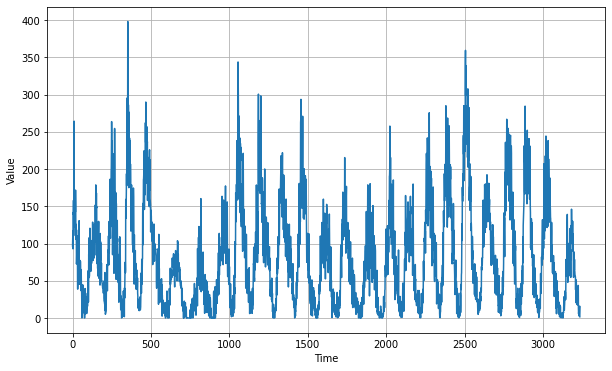

In [20]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time, series)

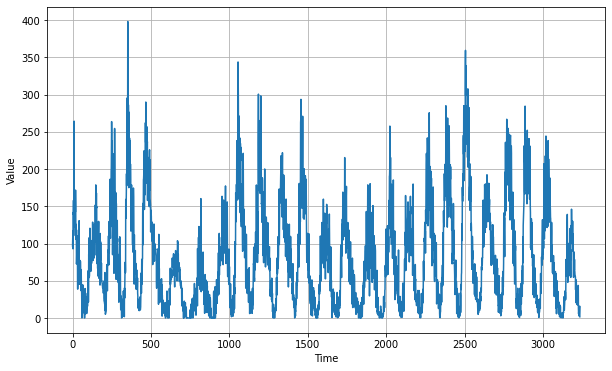

In [21]:
series = np.array(sunspots)
time = np.array(time_step)

plt.figure(figsize=(10,6))
plot_series(time, series)

In [22]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [24]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding='causal',
                           activation='relu',
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 **(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 3s 289ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 4s 292ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 4s 293ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 3s 285ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 6s 461ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 6s 479ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 4s 301ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 3s 282ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 3s 284ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 117ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 4s 119ms/step - loss: 25.7652 - mae: 26.2597
Epoch 3/500
30/30 [==============================] - 4s 118ms/step - loss: 22.0764 - mae: 22.5701
Epoch 4/500
30/30 [==============================] - 4s 120ms/step - loss: 20.4601 - mae: 20.9529
Epoch 5/500
30/30 [==============================] - 4s 117ms/step - loss: 19.7085 - mae: 20.2010
Epoch 6/500
30/30 [==============================] - 4s 119ms/step - loss: 19.3149 - mae: 19.8069
Epoch 7/500
30/30 [==============================] - 4s 118ms/step - loss: 18.7104 - mae: 19.2024
Epoch 8/500
30/30 [==============================] - 4s 118ms/step - loss: 18.1212 - mae: 18.6128
Epoch 9/500
30/30 [==============================] - 3s 116ms/step - loss: 18.0739 - mae: 18.5654
Epoch 10/500
30/30 [==============================] - 4s 119ms/step - loss: 17.9504 - mae: 18.4419
Epoch 11/500
30/30 

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

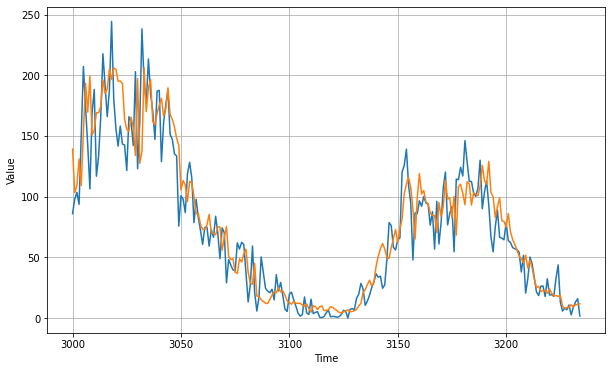

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.578633

<Figure size 432x288 with 0 Axes>

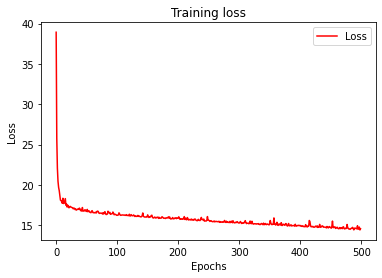

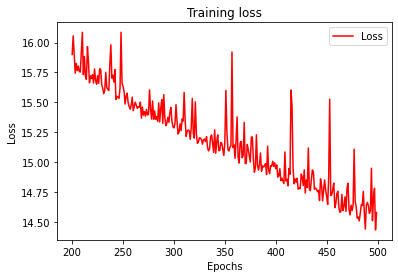

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[139.15103   103.257835  109.05441   130.89359   109.08462   153.4178
 193.28883   169.61122   199.3232    150.79306   154.66577   169.05086
 169.09581   174.28943   196.14844   185.09811   188.71524   205.1584
 196.61856   205.9072    205.13411   195.09193   195.27954   193.3103
 163.65907   155.46349   154.00629   165.5151    156.76578   133.8541
 197.17648   127.373795  137.33426   206.31989   170.01204   189.91432
 196.48901   161.69543   159.36363   168.61568   175.33371   180.99873
 166.26727   172.3437    189.59187   167.59026   163.6562    157.51883
 148.23448   142.09087   105.39492   113.20199   109.50565    95.979294
 112.715485  111.28803   100.15172    85.86907    85.80721    77.29033
  72.82231    73.21491    76.67298    85.29858    70.444885   69.41023
  68.492294   75.16827    74.93472    55.85606    66.53521    75.39296
  50.745155   48.12284    48.85459    37.720516   36.613567   48.817368
  46.141277   52.880486   56.690193   37.65856    28.604954   27.822231
  45.03